<a href="https://colab.research.google.com/github/AshishPawar24/UIDAI-DATA-HACKATHON/blob/main/UIDAI_Case_Studies_Anomaly_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")


Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/MyDrive/UIDAI_Hackathon/data"

ENROL_PATH = BASE_PATH + "/enrolment"
DEMO_PATH  = BASE_PATH + "/demographic_updates"


In [ ]:
enrolment_files = [
    "Malda_enrolment.csv",
    "Murshidabad_enrolment.csv",
    "Nadia_enrolment.csv",
    "North24Parganas_enrolment.csv",
    "Patna_enrolment.csv",
    "Muzaffarpur_enrolment.csv",
    "Gaya_enrolment.csv"
]

enrol_df = pd.concat(
    [pd.read_csv(os.path.join(ENROL_PATH, f)) for f in enrolment_files],
    ignore_index=True
)


In [ ]:
# Drop invalid rows
enrol_df = enrol_df.dropna(subset=["date", "state", "district", "pincode"])

# Parse date
enrol_df["date"] = pd.to_datetime(enrol_df["date"], dayfirst=True, errors="coerce")
enrol_df = enrol_df.dropna(subset=["date"])

# Convert age columns
age_cols = ["age_0_5", "age_5_17", "age_18_greater"]
for col in age_cols:
    enrol_df[col] = pd.to_numeric(enrol_df[col], errors="coerce").fillna(0)
    enrol_df = enrol_df[enrol_df[col] >= 0]

# Monthly aggregation key
enrol_df["month"] = enrol_df["date"].dt.to_period("M").astype(str)

# Decision-grade enrolment metrics
enrol_df["total_enrolments"] = enrol_df[age_cols].sum(axis=1)
enrol_df["adult_enrolments"] = enrol_df["age_18_greater"]


In [ ]:
pin_month_df = (
    enrol_df
    .groupby(["state", "district", "pincode", "month"], as_index=False)
    .agg({
        "total_enrolments": "sum",
        "adult_enrolments": "sum"
    })
)


In [ ]:
#PROBLEM 1 — LOCALIZED ENROLMENT VOLATILITY

#(West Bengal as demonstrative case)

wb_df = pin_month_df[pin_month_df["state"] == "West Bengal"].copy()

border_districts = ["Malda", "Murshidabad", "Nadia", "North 24 Parganas"]
wb_df["region_type"] = wb_df["district"].apply(
    lambda x: "High-Mobility" if x in border_districts else "Other"
)


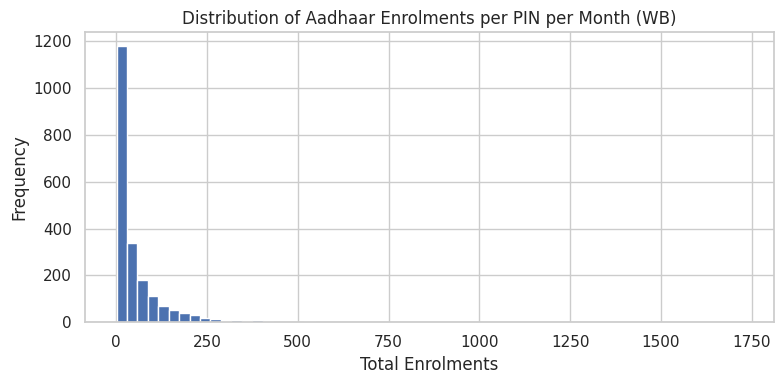

In [ ]:

plt.figure(figsize=(8,4))
plt.hist(wb_df["total_enrolments"], bins=60)
plt.title("Distribution of Aadhaar Enrolments per PIN per Month (WB)")
plt.xlabel("Total Enrolments")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [ ]:
wb_df["p95_pin"] = (
    wb_df.groupby("pincode")["total_enrolments"]
         .transform(lambda x: np.percentile(x, 95))
)


In [ ]:
wb_df["anomaly"] = wb_df["total_enrolments"] > wb_df["p95_pin"]


In [ ]:

wb_summary = (
    wb_df.groupby("region_type")
         .agg(
             anomaly_rate=("anomaly", "mean"),
             avg_enrolments=("total_enrolments", "mean")
         )
         .reset_index()
)

wb_summary
//OP

,region_type,anomaly_rate,avg_enrolments
0,High-Mobility,0.161645,54.120038


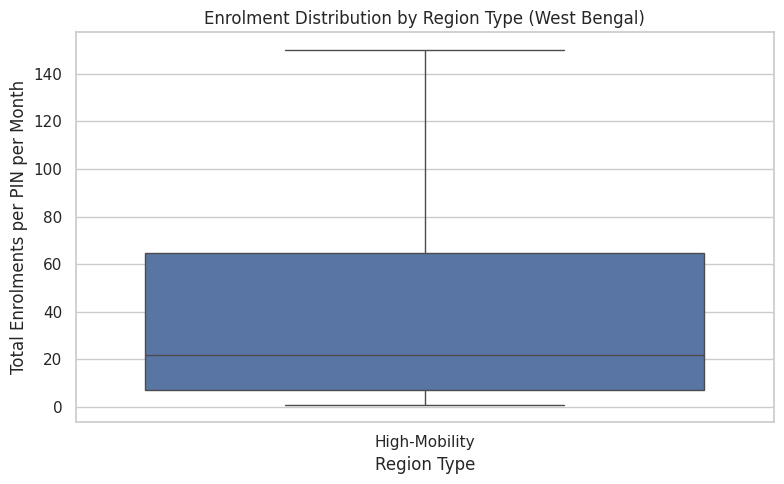

In [ ]:
//BOXPLOT IP
plt.figure(figsize=(8,5))
sns.boxplot(
    data=wb_df,
    x="region_type",
    y="total_enrolments",
    showfliers=False
)
plt.title("Enrolment Distribution by Region Type (West Bengal)")
plt.xlabel("Region Type")
plt.ylabel("Total Enrolments per PIN per Month")
plt.tight_layout()
plt.show()
//OP

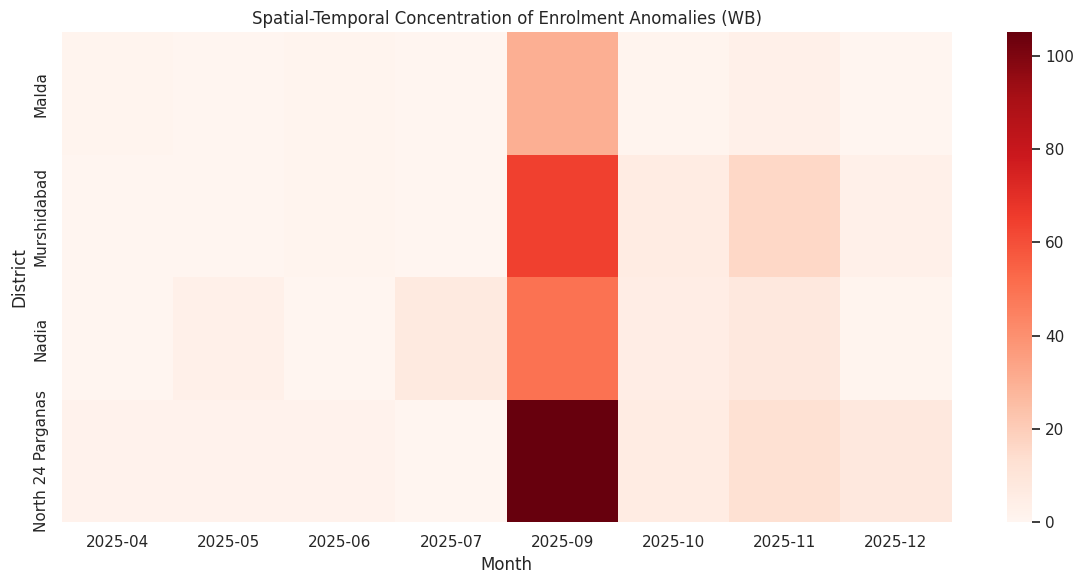

In [ ]:

heatmap_data = (
    wb_df[wb_df["anomaly"]]
    .groupby(["district", "month"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="Reds")
plt.title("Spatial-Temporal Concentration of Enrolment Anomalies (WB)")
plt.xlabel("Month")
plt.ylabel("District")
plt.tight_layout()
plt.show()
//HEATMAP OP

In [ ]:
#PROBLEM 2 — ELECTION-SENSITIVE ENROLMENT STRESS

//first

#(Bihar – 2025 elections)

bihar_df = pin_month_df[pin_month_df["state"] == "Bihar"].copy()

bihar_df["pre_election"] = bihar_df["month"].between("2025-05", "2025-10")


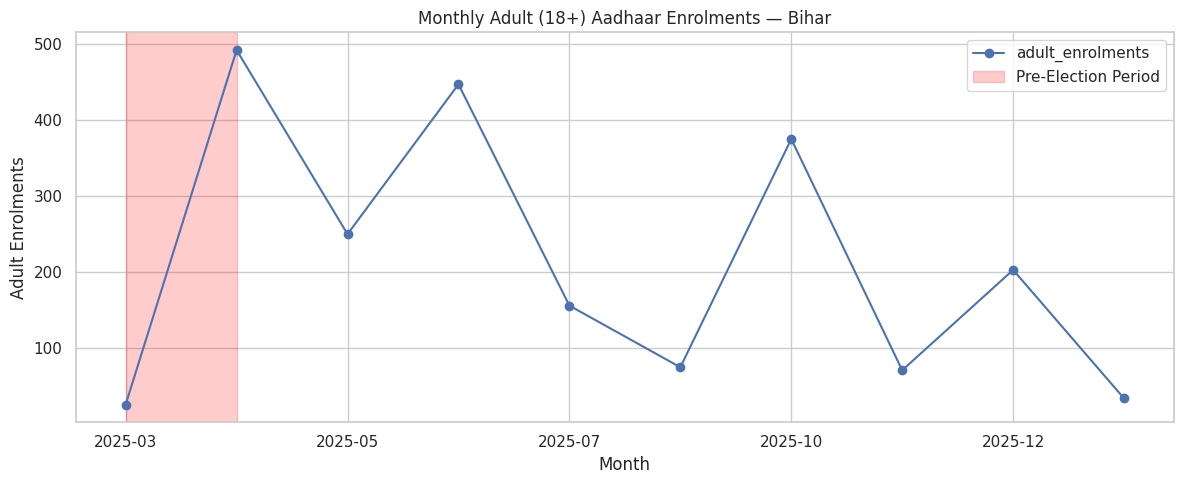

In [ ]:
monthly_adult = bihar_df.groupby("month")["adult_enrolments"].sum()

plt.figure(figsize=(12,5))
monthly_adult.plot(marker="o")
plt.axvspan("2025-05", "2025-10", color="red", alpha=0.2, label="Pre-Election Period")
plt.title("Monthly Adult (18+) Aadhaar Enrolments — Bihar")
plt.xlabel("Month")
plt.ylabel("Adult Enrolments")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
//2nd

bihar_event_summary = (
    bihar_df.groupby("pre_election")["adult_enrolments"]
            .mean()
            .reset_index()
)

bihar_event_summary


,pre_election,adult_enrolments
0,False,1.735294
1,True,2.664622
